In [1]:
from scipy import optimize
import matplotlib.pyplot as plt
import dolfin as dl
import numpy as np
from cuqi.model import PDEModel
from cuqi.distribution import Gaussian, Posterior
from cuqi.array import CUQIarray
from cuqipy_fenics.pde import SteadyStateLinearFEniCSPDE
from cuqipy_fenics.geometry import FEniCSContinuous, MaternKLExpansion
from cuqi.geometry import Geometry, MappedGeometry, _WrappedGeometry, Continuous1D
from cuqi.experimental.mcmc import MH,NUTS, PCN
import cuqipy_fenics
ufl = cuqipy_fenics.utilities._LazyUFLLoader()

## Building a FEniCS based Poisson problem <a class="anchor" id="PDEproblem"></a>

In this section, we use FEniCS python library to build a PDE model. 

The PDE model we consider here is a 2D steady-state problem (Poisson):

$$
\begin{align*}
 -\nabla \cdot \left(a(\xi) \nabla u(\xi)\right) &= f(\xi) \;\;\;\;\xi=[\xi^1, \xi^2]^\mathrm{T} \in (0,1)\times(0,1),\\
u(\xi)&=0 \;\;\;\;\mathrm{on}\; \xi^1=0\\
u(\xi)&=0 \;\;\;\;\mathrm{on}\; \xi^1=1 \\
a(\xi)\nabla u(\xi)\cdot n&=0 \;\;\;\;\mathrm{on}\; \xi^2=0 \\
a(\xi)\nabla u(\xi)\cdot n&=0 \;\;\;\;\mathrm{on}\; \xi^2=1 
\end{align*}
$$



- where $a(\xi)$ is the conductivity, $u(\xi)$ is the PDE solution (potential), $f(\xi)$ is the source term.


- We denote the discretized system that we need to solve as
$\mathbf{A}(\mathbf{m})\mathbf{U} = \mathbf{F}$
  - $\mathbf{A}$ is the discretized diffusion differential operator
  - $\mathbf{m}$ is the discretized unknown parameter 
  - $\mathbf{U}$ is the discretized solution (the potential)
  - $\mathbf{F}$ is the discretized RHS (the source term) 

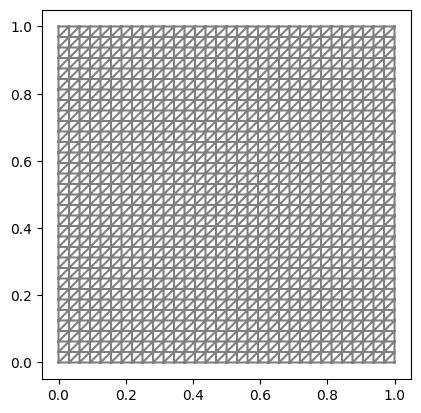

In [2]:
n_ksi_1 = 32 # number of vertices on the ksi_1 dimension
n_ksi_2 = 32 # number of vertices on the ksi_2 dimension
mesh = dl.UnitSquareMesh(n_ksi_1, n_ksi_2) # create FEniCS mesh
dl.plot(mesh)


In [32]:
solution_function_space = dl.FunctionSpace(mesh, 'Lagrange', 1) # function space for solution u
parameter_function_space = dl.FunctionSpace(mesh, 'DG', 0) # function space for solution a

In [33]:
# Function (where do we have Dirichlet BC)
def u_boundary(ksi, on_boundary):
  return on_boundary
    # return on_boundary and ( ksi[0] < dl.DOLFIN_EPS or ksi[0] > 1.0 - dl.DOLFIN_EPS)

# Expression (what is the value on these Dirichlet BC)
dirichlet_bc_expr = dl.Expression("0", degree=1)

# FEniCS Dirichlet BC Object
dirichlet_bc = dl.DirichletBC(solution_function_space,
                              dirichlet_bc_expr,
                              u_boundary) 


In [69]:
f = dl.Constant(10)

In [70]:
# FEniCS measure for integration
dksi = dl.Measure('dx', domain=mesh)

# The weak form of the PDE
def form(a,u,p):
    return a*ufl.inner(ufl.grad(u), ufl.grad(p))*dksi - f*p*dksi


In [36]:
PDE = SteadyStateLinearFEniCSPDE( 
        form,
        mesh, 
        parameter_function_space=parameter_function_space,
        solution_function_space=solution_function_space,
        dirichlet_bcs=dirichlet_bc)

In [37]:
# Create homogeneous parameter m_1(ksi) = 1

# Create a FEniCS function for the parameter
a_1 = dl.Function(parameter_function_space)

# Assign the value 1 to the FEniCS function by interpolating a FEniCS Constant object.
a_1.interpolate(dl.Constant(1.0))

In [38]:
# Assemble the PDE at m_1
PDE.assemble(a_1)

# Solve the PDE at m_1
u, _ = PDE.solve()

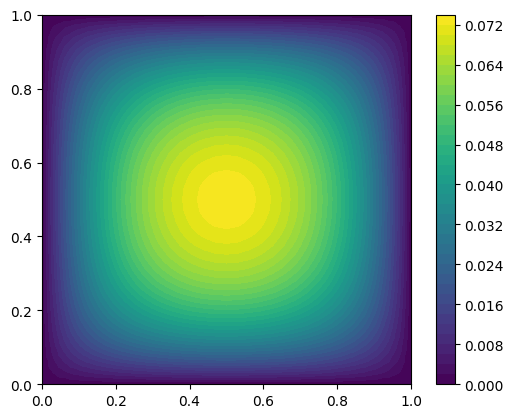

In [39]:
im = dl.plot(u)
plt.colorbar(im)

## Check if the forward model give us the same vallues

In [40]:
theta0 = np.loadtxt("/Users/naoki/Desktop/CUQIpy_project/CUQIpy-Benchmarks/sandbox/wolfgang/theta.0.txt")

In [41]:
np.shape(theta0)

(64,)

##  Building and solving the Bayesian inverse problem in CUQIpy <a class="anchor" id="Bayesian_problem"></a>
  
The goal is to infer the log conductivity profile $m(\xi)$ given observed data $y^\mathrm{obs}$. These observation can be of the potential directly, i.e. $y^\mathrm{obs}=u(\xi)$, or a function of the potential. 

The data $y^\mathrm{obs}$ is then given by:

$$ y^\mathrm{obs} = \mathcal{G}(m) + \eta$$


where 
- $\eta$ is the measurement noise
- $\mathcal{G}$ is the forward model operator which maps $m$ to the observations.


In [42]:
# user expresstion for 1 in the sepcified grid and 0 in the other
class Expression(dl.UserExpression):
    def __init__(self, degree, x_lim, y_lim):
        self.x_lim = x_lim
        self.y_lim = y_lim
        super().__init__(degree=degree)
    def eval(self, value, x):
        if x[0] >self.x_lim[0] and x[0] < self.x_lim[1] and x[1] > self.y_lim[0] and x[1] < self.y_lim[1]:
            value[0] = 1
        else:
            value[0] = 0

In [78]:
class StepExpansion(_WrappedGeometry):
    """A geometry class that builds spectral representation of step expansion
    Parameters
    -----------
    geometry : cuqi.fenics.geometry.Geometry
        An input geometry on which the Matern field representation is built (the geometry must have a mesh attribute)

    num_steps: int
        Number of expansion terms to represent the Matern field realization


    Example
    -------
    .. code-block:: python

        import numpy as np
        import matplotlib.pyplot as plt
        from cuqi.fenics.geometry import MaternKLExpansion, FEniCSContinuous
        from cuqi.distribution import Gaussian
        import dolfin as dl
        
        mesh = dl.UnitSquareMesh(20,20)
        V = dl.FunctionSpace(mesh, 'CG', 1)
        geometry = FEniCSContinuous(V)
        MaternGeometry = MaternKLExpansion(geometry, 
                                        length_scale = .2,
                                        num_terms=128)
        
        MaternField = Gaussian(mean=np.zeros(MaternGeometry.dim),
                        cov=np.eye(MaternGeometry.dim),
                        geometry= MaternGeometry)
        
        samples = MaternField.sample()
        samples.plot()

    """

    def __init__(self, geometry, num_steps = 64, normalize=True): 
        super().__init__(geometry)
        if not hasattr(geometry, 'mesh'):
            raise NotImplementedError
        self._num_steps = num_steps
        self._build_basis() 
        
    @property
    def funvec_shape(self):
        """The shape of the geometry (shape of the vector representation of the
        function value)."""
        return self.geometry.funvec_shape
    
    @property
    def par_shape(self):
        return (self.num_steps,)


    @property
    def num_steps(self):
        return self._num_steps

    @property
    def function_space(self):
        return self.geometry.function_space
    
    @property
    def step_vec(self):
        return self._step_vec
    
    @property
    def physical_dim(self):
        """Returns the physical dimension of the geometry, e.g. 1, 2 or 3"""
        return self.geometry.physical_dim

    def __repr__(self) -> str:
        return "{} on {}".format(self.__class__.__name__,self.geometry.__repr__())

    def par2fun(self,a):
        return self.geometry.par2fun(self.par2field(a))

    def fun2vec(self,fun):
        """ Maps the function value (FEniCS object) to the corresponding vector
        representation of the function (ndarray of the function DOF values)."""
        return self.geometry.fun2vec(fun)
    
    def vec2fun(self,funvec):
        """ Maps the vector representation of the function (ndarray of the
        function DOF values) to the function value (FEniCS object)."""
        return self.geometry.vec2fun(funvec)

    # def gradient(self, direction, wrt):
    #     direction = self.geometry.gradient(direction, wrt)
    #     return np.diag( np.sqrt(self.eig_val)).T@self.eig_vec.T@direction
        
    def par2field(self, a):
        """Applies linear transformation of the parameters a to
        generate a realization of the step expansion (given that a is the coefficient of conductivity)"""

        if self._step_vec is None:
            self._build_basis() 
	   
        a = self._process_values(a)
        Ns = a.shape[-1]
        field_list = np.empty((self.geometry.par_dim,Ns))

        for idx in range(Ns):
            # For more details about the formulation below, see section 4.3 in
            # Chen, V., Dunlop, M. M., Papaspiliopoulos, O., & Stuart, A. M.
            # (2018). Dimension-robust MCMC in Bayesian inverse problems.
            # arXiv preprint arXiv:1803.03344.
            field_list[:,idx] = self.step_vec@(a[...,idx] )

        if len(field_list) == 1:
            return field_list[0]
        else:
            return field_list

    def _build_basis(self):
        """Builds the basis of step expansion"""
        u = dl.Function(parameter_function_space)
        self._step_vec = np.zeros( [ u.vector().get_local().shape[0], self.num_steps ] )

        for i in range( self.num_steps ):   
            u.interpolate(Expression(degree=0, x_lim=[(i%8) /8 , (i%8 + 1) / 8 ], y_lim=[i//8 /8 , (i//8 + 1 ) / 8 ]))
            self._step_vec[:,i] = u.vector().get_local()
            
        

        

In [74]:
k = int(np.sqrt(64))
print(k)

8


In [44]:
# Define CUQI geometry on which m is defined
fenics_continuous_geo = FEniCSContinuous(parameter_function_space,
                                         labels=['$\\xi_1$', '$\\xi_2$'])

# Define the MaternExpansion geometry that maps the i.i.d random variables to
# Matern field realizations
domain_geometry = StepExpansion(fenics_continuous_geo,
                                    num_steps=64)

range_geometry = FEniCSContinuous(solution_function_space,
                                  labels=['$\\xi_1$', '$\\xi_2$'])

In [45]:
cuqi_model = PDEModel(PDE, domain_geometry=domain_geometry, range_geometry=range_geometry)

In [ ]:
# View the first 10 vectors
for i in range(10):
    plt.figure()
    fenics_continuous_geo.plot(domain_geometry.step_vec[:,i]) 
    plt.show()

In [47]:
x = Gaussian(np.zeros(cuqi_model.domain_dim), cov=1, geometry=domain_geometry)

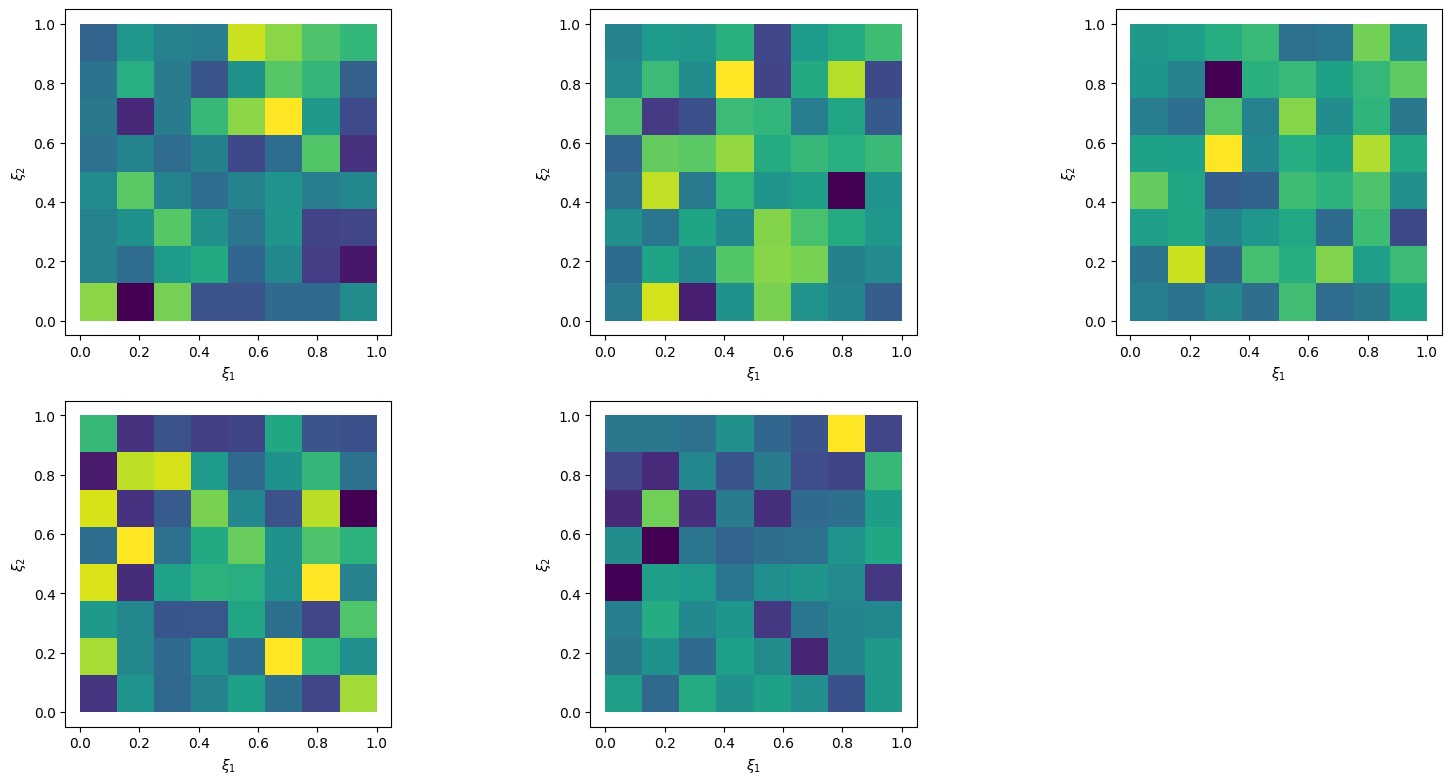

In [48]:
prior_samples = x.sample(5)
prior_samples.plot()

In [49]:
np.random.seed(1)
theta0 = np.loadtxt("/Users/naoki/Desktop/CUQIpy_project/CUQIpy-Benchmarks/sandbox/wolfgang/theta.0.txt")
exact_solution = theta0
# # plot exact solution
# im = exact_solution.plot()
# plt.colorbar(im[0])

In [50]:
exact_data = cuqi_model(exact_solution)

# plot exact data
# im = range_geometry.plot(exact_data)
# plt.colorbar(im[0])

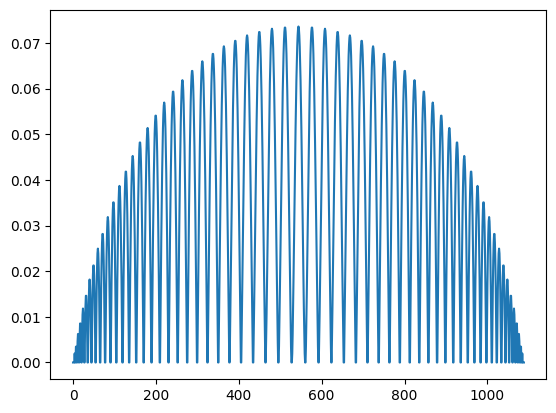

In [88]:
plt.plot(exact_data)

<bound method Function.function_space of Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 1)), 1876)>


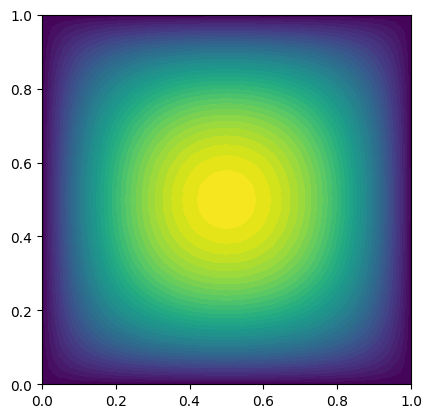

In [80]:
sol = dl.Function(solution_function_space)
sol.vector()[:] = exact_data
dl.plot(sol)

In [87]:
exact_data

array([0., 0., 0., ..., 0., 0., 0.])

In [61]:

z = []
for i in range(1,14):
  for j in range(1,14):
    z.append(sol([i /14,j /14]))


In [71]:
print(len(z))

169


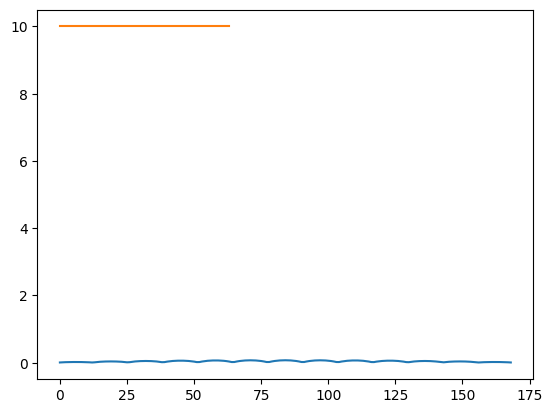

In [68]:
plt.plot(z)
plt.plot(z0)

In [64]:
theta0

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [65]:
theta1 = np.loadtxt("/Users/naoki/Desktop/CUQIpy_project/CUQIpy-Benchmarks/sandbox/wolfgang/theta.1.txt")

In [66]:
theta1

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [67]:
z0 = np.loadtxt("/Users/naoki/Desktop/CUQIpy_project/CUQIpy-Benchmarks/sandbox/wolfgang/theta.1.txt")

In [ ]:
np.savetxt("")

In [53]:
y = Gaussian(mean=cuqi_model(x), cov=1, geometry=range_geometry)
y
y_obs = exact_data

In [54]:
L = y(y=y_obs)
cuqi_posterior = Posterior(L, x)


Sample: 100%|██████████| 100/100 [00:02<00:00, 41.25it/s]


CUQIpy Samples:
---------------

Ns (number of samples):
 110

Geometry:
 StepExpansion on FEniCSContinuous(2048,)

Shape:
 (64, 110)

Samples:
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]




AttributeError: 'numpy.ndarray' object has no attribute 'plot'

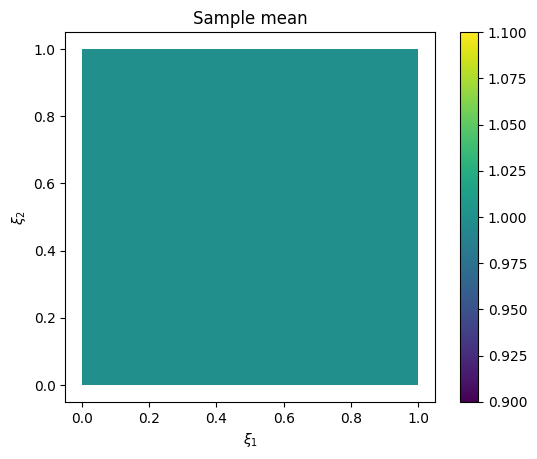

<Figure size 640x480 with 0 Axes>

In [55]:
Ns = 100
sampler = MH(cuqi_posterior)
sampler.warmup(10)
sampler.sample(Ns)
samples_MH = sampler.get_samples() # ToDo: Allow burn-in removal in get_samples method
print(samples_MH)
# plot samples mean
im = samples_MH.plot_mean()
cb = plt.colorbar(im[0])

# plot the exact solution
plt.figure()
im = exact_solution.plot()
cb = plt.colorbar(im[0])
plt.title('Exact solution')

In [75]:
array  =np.array(
     [0.06076511762259369, 0.09601910120848481,
      0.1238852517838584,  0.1495184117375201,
      0.1841596127549784,  0.2174525028261122,
      0.2250996160898698,  0.2197954769002993,
      0.2074695698370926,  0.1889996477663016,
      0.1632722532153726,  0.1276782480038186,
      0.07711845915789312, 0.09601910120848552,
      0.2000589533367983,  0.3385592591951766,
      0.3934300024647806,  0.4040223892461541,
      0.4122329537843092,  0.4100480091545554,
      0.3949151637189968,  0.3697873264791232,
      0.33401826235924,    0.2850397806663382,
      0.2184260032478671,  0.1271121156350957,
      0.1238852517838611,  0.3385592591951819,
      0.7119285162766475,  0.8175712861756428,
      0.6836254116578105,  0.5779452419831157,
      0.5555615956136897,  0.5285181561736719,
      0.491439702849224,   0.4409367494853282,
      0.3730060082060772,  0.2821694983395214,
      0.1610176733857739,  0.1495184117375257,
      0.3934300024647929,  0.8175712861756562,
      0.9439154625527653,  0.8015904115095128,
      0.6859683749254024,  0.6561235366960599,
      0.6213197201867315,  0.5753611315000049,
      0.5140091754526823,  0.4325325506354165,
      0.3248315148915482,  0.1834600412730086,
      0.1841596127549917,  0.4040223892461832,
      0.6836254116578439,  0.8015904115095396,
      0.7870119561144977,  0.7373108331395808,
      0.7116558878070463,  0.6745179049094283,
      0.6235300574156917,  0.5559332704045935,
      0.4670304994474178,  0.3499809143811,
      0.19688263746294,    0.2174525028261253,
      0.4122329537843404,  0.5779452419831566,
      0.6859683749254372,  0.7373108331396063,
      0.7458811983178246,  0.7278968022406559,
      0.6904793535357751,  0.6369176452710288,
      0.5677443693743215,  0.4784738764865867,
      0.3602190632823262,  0.2031792054737325,
      0.2250996160898818,  0.4100480091545787,
      0.5555615956137137,  0.6561235366960938,
      0.7116558878070715,  0.727896802240657,
      0.7121928678670187,  0.6712187391428729,
      0.6139157775591492,  0.5478251665295381,
      0.4677122687599031,  0.3587654911000848,
      0.2050734291675918,  0.2197954769003094,
      0.3949151637190157,  0.5285181561736911,
      0.6213197201867471,  0.6745179049094407,
      0.690479353535786,   0.6712187391428787,
      0.6178408289359514,  0.5453605027237883,
      0.489575966490909,   0.4341716881061278,
      0.3534389974779456,  0.2083227496961347,
      0.207469569837099,   0.3697873264791366,
      0.4914397028492412,  0.5753611315000203,
      0.6235300574157017,  0.6369176452710497,
      0.6139157775591579,  0.5453605027237935,
      0.4336604929612851,  0.4109641743019312,
      0.3881864790111245,  0.3642640090182592,
      0.2179599909280145,  0.1889996477663011,
      0.3340182623592461,  0.4409367494853381,
      0.5140091754526943,  0.5559332704045969,
      0.5677443693743304,  0.5478251665295453,
      0.4895759664908982,  0.4109641743019171,
      0.395727260284338,   0.3778949322004734,
      0.3596268271857124,  0.2191250268948948,
      0.1632722532153683,  0.2850397806663325,
      0.373006008206081,   0.4325325506354207,
      0.4670304994474315,  0.4784738764866023,
      0.4677122687599041,  0.4341716881061055,
      0.388186479011099,   0.3778949322004602,
      0.3633362567187364,  0.3464457261905399,
      0.2096362321365655,  0.1276782480038148,
      0.2184260032478634,  0.2821694983395252,
      0.3248315148915535,  0.3499809143811097,
      0.3602190632823333,  0.3587654911000799,
      0.3534389974779268,  0.3642640090182283,
      0.35962682718569,    0.3464457261905295,
      0.3260728953424643,  0.180670595355394,
      0.07711845915789244, 0.1271121156350963,
      0.1610176733857757,  0.1834600412730144,
      0.1968826374629443,  0.2031792054737354,
      0.2050734291675885,  0.2083227496961245,
      0.2179599909279998,  0.2191250268948822,
      0.2096362321365551,  0.1806705953553887,
      0.1067965550010013])


In [77]:
np.save('data_wolfgang.npy', array)